### Judd Anderman  
### Data 602 Project
### Regression and Geospatial Analysis of NYC Air Quality and Ashtma-Related Hospitalizations  
### May 29, 2017  

#### Import required packages

In [160]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
import math
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal as ps
import seaborn as sns
import folium
import tabula
import zipfile
import io
import os
from bs4 import BeautifulSoup
from pandas.tools.plotting import scatter_matrix
from ipywidgets import (
    Dropdown, Button, Layout, Box, Label, HBox, VBox, interact, interactive
)
from IPython.display import display, clear_output

%matplotlib inline

#### Function definitions

Function to retrieve NYC air quality and NYS inpatient discharges data through API calls

Not used in this notebook, but used earlier in .py script to fetch data

In [161]:
def soda_data(end_pt):
    token = 'Usj2xbIj0MccORApWzL94Y1dh'

    url = end_pt + '?$$app_token=' + token

    q_count = requests.get(url + '&$select=count(*)')
    recs = pd.read_json(q_count.text)["count"][0]

    if recs <= 50000:
        query = url + '&$limit=' + str(recs)
        r = requests.get(query)
        data = pd.read_json(r.text)
    else:
        pages = int(math.ceil(float(recs) / 50000))
        query = url + '&$limit=50000&$offset='
        df = []

        for i in range(0,pages):
            r = requests.get(query + str(i * 50000))
            df.append(pd.read_json(r.text))

        data = pd.concat(df)

    return data

In [162]:
def lin_func(x, m, b):
    return m * x + b

Function to retrieve and unzip UHF 42 Neighborhood shapefile archive to this notebook's working directory

In [163]:
def get_unzip_shp():
    cwd = os.getcwd()
    url_zip = 'https://github.com/juddanderman/Data_602_Project/raw/master/uhf42_dohmh_2009.zip'
    shp_data = requests.get(url_zip, stream = True)
    
    with zipfile.ZipFile(io.BytesIO(shp_data.content)) as zf:       
        zf.extractall(cwd)

In [164]:
def corr_map(df, air_q, asthma):
    uhf42 = gpd.GeoDataFrame.from_file('UHF_42_DOHMH_2009/UHF_42_DOHMH_2009.shp')
    uhf42 = pd.merge(uhf42, df, on = 'UHFCODE', how = 'left')
    uhf42 = uhf42.iloc[1:43]

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))

    df.plot.scatter(air_q, asthma, ax = ax1)
    ax1.set_xlabel(air_q)
    ax1.set_ylabel(asthma.replace('_', ' '))
    coef = sp.optimize.curve_fit(lin_func, df[air_q], df[asthma])[0]
    if (coef[1] >= 0):
        eq = 'admit_rate = {:.1f} * air_quality + {:.1f}'.format(
            coef[0], coef[1]
            )
    else:
        eq = 'admit_rate = {:.1f} * air_quality - {:.1f}'.format(
            coef[0], -coef[1]
            )
    ax1.plot(df[air_q], lin_func(df[air_q], *coef), 'r-')
    r_sq = np.corrcoef(df[air_q], df[asthma])[0, 1]**2

    txt = eq + ', R^2 = {:.3f}'.format(r_sq)
    ax1.set_title(txt)
    
    uhf42 = uhf42.to_crs(epsg = '4326')
    ax2.patch.set_alpha(1)
    a = uhf42.plot(column = air_q, scheme = 'QUANTILES', k = 5,
               cmap = 'YlOrRd', alpha = 0.7, ax = ax2, 
               edgecolor = 'white', legend = True)
    leg1 = ax2.get_legend()
    leg1._set_loc(2)
    leg1.set_title(air_q)
     
    b = uhf42.plot(column = asthma, scheme = 'QUANTILES', k = 5,
               cmap = 'YlGnBu', alpha = 0.7, ax = ax3,
               edgecolor = 'white', legend = True)
    leg2 = ax3.get_legend()
    leg2._set_loc(2)

    if asthma == 'PDI_14':
        lab = 'Admission Rate 2-17 yrs'
    elif asthma == 'PQI_15':
        lab = 'Admission Rate 18-39 yrs'
    elif asthma == 'PQI_05':
        lab = 'Admission Rate 40+ yrs'

    leg2.set_title(lab)
    ax2.set_title('Air Quality by UHF Neighborhood')
    ax3.set_title('Hospitalization Rate by UHF Neighborhood')
    if df.name == 'inpatient':
        title = ('NYC Air Quality & Asthma Related Hospitalizations ' +
                 '(All Inpatient Admissions)')
    elif df.name == 'medicaid':
        title = ('NYC Air Quality & Asthma Related Hospitalizations ' +
                 '(All Medicaid Admissions)')
    plt.suptitle(title)
    plt.close()
    return f

Alternate version of function above with stacked, bivariate chloropleth map; not used in this notebook

In [165]:
def corr_map_stacked(df, air_q, asthma):
    uhf42 = gpd.GeoDataFrame.from_file('UHF_42_DOHMH_2009/UHF_42_DOHMH_2009.shp')
    uhf42 = pd.merge(uhf42, df, on = 'UHFCODE', how = 'left')
    uhf42 = uhf42.iloc[1:42]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    df.plot.scatter(air_q, asthma, ax = ax1)
    ax1.set_xlabel(air_q)
    ax1.set_ylabel(asthma.replace('_', ' '))
    coef = sp.optimize.curve_fit(lin_func, df[air_q], df[asthma])[0]
    if (coef[1] >= 0):
        eq = 'admit_rate = {:.1f} * air_quality + {:.1f}'.format(
            coef[0], coef[1]
            )
    else:
        eq = 'admit_rate = {:.1f} * air_quality - {:.1f}'.format(
            coef[0], -coef[1]
            )
    ax1.plot(df[air_q], lin_func(df[air_q], *coef), 'r-')
    r_sq = np.corrcoef(df[air_q], df[asthma])[0, 1]**2

    txt = eq + ', R^2 = {:.3f}'.format(r_sq)
    ax1.set_title(txt)
    
    uhf42 = uhf42.to_crs(epsg = '4326')
    ax2.patch.set_alpha(1)
    a = uhf42.plot(column = air_q, scheme = 'QUANTILES', k = 5,
               cmap = 'YlOrRd', alpha = 0.7, ax = ax2, 
               edgecolor = 'white', legend = True)
    leg1 = ax2.get_legend()
    leg1._set_loc(6)
    leg1.set_title(air_q)
     
    b = uhf42.plot(column = asthma, scheme = 'QUANTILES', k = 5,
               cmap = 'YlGnBu', alpha = 0.7, ax = ax2,
               edgecolor = 'white', legend = True)
    leg2 = ax2.get_legend()
    leg2._set_loc(2)

    if asthma == 'PDI_14':
        lab = 'Admission Rate 2-17 yrs'
    elif asthma == 'PQI_15':
        lab = 'Admission Rate 18-39 yrs'
    elif asthma == 'PQI_05':
        lab = 'Admission Rate 40+ yrs'

    leg2.set_title(lab)
    f.gca().add_artist(leg1)
    ax2.set_title('United Health Fund (UHF) Neighborhood')
    if df.name == 'inpatient':
        title = ('NYC Air Quality & Asthma Related Hospitalizations ' +
                 '(All Inpatient Admissions)')
    elif df.name == 'medicaid':
        title = ('NYC Air Quality & Asthma Related Hospitalizations ' +
                 '(All Medicaid Admissions)')
    plt.suptitle(title)
    return f

Bivariate chloropleth map built with Folium library

In [167]:
def folium_map(df, air_q, asthma):
    uhf42 = gpd.GeoDataFrame.from_file('UHF_42_DOHMH_2009/UHF_42_DOHMH_2009.shp')
    uhf42 = pd.merge(uhf42, df, on = 'UHFCODE', how = 'left')
    uhf42 = uhf42.iloc[1:43]
    uhf_str = uhf42.to_crs(epsg = '4326').to_json()
    m = folium.Map(location = [40.73, -74], zoom_start = 10)
    m.choropleth(geo_str = uhf_str,
                 data = uhf42,
                 columns = ['UHFCODE', air_q],
                 key_on = 'feature.properties.UHFCODE',
                 fill_color = 'YlOrRd',
                 fill_opacity = 0.7,
                 legend_name = air_q)

    if asthma == 'PDI_14':
        lab = 'Admission Rate 2-17 yrs'
    elif asthma == 'PQI_15':
        lab = 'Admission Rate 18-39 yrs'
    elif asthma == 'PQI_05':
        lab = 'Admission Rate 40+ yrs'

    m.choropleth(geo_str = uhf_str,
                 data = uhf42,
                 columns = ['UHFCODE', asthma],
                 key_on = 'feature.properties.UHFCODE',
                 fill_color = 'YlGnBu',
                 fill_opacity = 0.7,
                 legend_name = lab)
    return m

#### Import, clean, and process data

Set plotting aesthetics

In [168]:
sns.set_style('ticks')

Read in NYC air quality and NYS inpatient clinical quality measures datasets from remote GitHub repository

Data sourced from: 
- https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/data  
- https://health.data.ny.gov/Health/Medicaid-Inpatient-Prevention-Quality-Indicators-P/h6vj-9z3w/data  
- https://health.data.ny.gov/Health/Hospital-Inpatient-Prevention-Quality-Indicators-P/2xc5-n3zd/data  
- https://health.data.ny.gov/Health/Medicaid-Inpatient-Prevention-Quality-Indicators-P/izyt-3msa/data  
- https://health.data.ny.gov/Health/Hospital-Inpatient-Prevention-Quality-Indicators-P/5q8c-d6xq/data  

In [169]:
base = 'https://raw.githubusercontent.com/juddanderman/Data_602_Project/master/'
url_air = base + 'Air_Quality.csv'
air_qual = pd.read_csv(url_air, index_col = 0)
air_qual = air_qual.loc[air_qual['geo_type_name'] == 'UHF42']
air_qual = air_qual.drop_duplicates()
air_qual.head()

,data_valuemessage,geo_entity_id,geo_entity_name,geo_type_name,indicator_data_id,indicator_id,measure,name,year_description
6,2.9,101,Kingsbridge - Riverdale,UHF42,130685,646,Average Concentration,Air Toxics Concentrations- Average Benzene Con...,2005
7,2.8,102,Northeast Bronx,UHF42,130686,646,Average Concentration,Air Toxics Concentrations- Average Benzene Con...,2005
8,2.7,103,Fordham - Bronx Pk,UHF42,130687,646,Average Concentration,Air Toxics Concentrations- Average Benzene Con...,2005
9,2.7,104,Pelham - Throgs Neck,UHF42,130688,646,Average Concentration,Air Toxics Concentrations- Average Benzene Con...,2005
10,3.0,105,Crotona -Tremont,UHF42,130689,646,Average Concentration,Air Toxics Concentrations- Average Benzene Con...,2005


In [170]:
url_pdi_med = base + 'PDI_Medicaid_Pediatric_Asthma.csv'
url_pqi_med = base + 'PQI_Medicaid_Adult_Asthma.csv'
url_pdi_all = base + 'PDI_Pediatric_Asthma.csv'
url_pqi_all = base + 'PQI_Adult_Asthma.csv'

pdi_medicaid_peds = pd.read_csv(url_pdi_med, index_col = 0)
pqi_medicaid_adult = pd.read_csv(url_pqi_med, index_col = 0)
pdi_medicaid_peds = pdi_medicaid_peds[[
    'discharge_year',
    'medicaid_pdi_hospitalizations',
    'observed_rate_per_100_000_people',
    'pdi_number',
    'zip_code',
    'zip_code_medicaid_population']]
pdi_medicaid_peds = pdi_medicaid_peds.rename(
    columns = {'discharge_year': 'year',
               'medicaid_pdi_hospitalizations': 'hospitalizations',
               'observed_rate_per_100_000_people': 'observed_rate',
               'pdi_number': 'measure',
               'zip_code_medicaid_population': 'population'}
    )
pqi_medicaid_adult = pqi_medicaid_adult[[
    'discharge_year',
    'medicaid_pqi_hospitalizations',
    'observed_rate_per_100_000_people',
    'pqi_number',
    'zip_code',
    'zip_code_medicaid_population']]
pqi_medicaid_adult = pqi_medicaid_adult.rename(
    columns = {'discharge_year': 'year',
               'medicaid_pqi_hospitalizations': 'hospitalizations',
               'observed_rate_per_100_000_people': 'observed_rate',
               'pqi_number': 'measure',
               'zip_code_medicaid_population': 'population'}
    )

medicaid_asthma = pd.concat([pdi_medicaid_peds, pqi_medicaid_adult],
                            ignore_index = True
                            )
medicaid_asthma['zip_code'].unique()
medicaid_asthma = medicaid_asthma[
    medicaid_asthma['zip_code'] != 'Statewide'].reset_index()
medicaid_asthma.loc[medicaid_asthma['zip_code'] == '63', 'zip_code'] = '063'

pdi_pediatric = pd.read_csv(url_pdi_all, index_col = 0)
pqi_adult = pd.read_csv(url_pqi_all, index_col = 0)
pdi_pediatric = pdi_pediatric[[
    'discharge_year',
    'observed_rate_per_100_000_people',
    'patient_zip_code',
    'pdi_number']]
pdi_pediatric = pdi_pediatric.rename(
    columns = {'discharge_year': 'year',
               'observed_rate_per_100_000_people': 'observed_rate',
               'patient_zip_code': 'zip_code',
               'pdi_number': 'measure'}
    )
pqi_adult = pqi_adult[[
    'year',
    'observed_rate_per_100_000_people',
    'patient_zipcode',
    'pqi_number']]
pqi_adult = pqi_adult.rename(
    columns = {'observed_rate_per_100_000_people': 'observed_rate',
               'patient_zipcode': 'zip_code',
               'pqi_number': 'measure'}
    )

inpt_asthma = pd.concat([pdi_pediatric, pqi_adult],
                        ignore_index = True
                        )
inpt_asthma['zip_code'].unique()
inpt_asthma = inpt_asthma[
    inpt_asthma['zip_code'] != 'STATEWIDE'].reset_index()
inpt_asthma.loc[inpt_asthma['zip_code'] == '6390', 'zip_code'] = '06390'

medicaid_14 = medicaid_asthma[medicaid_asthma['year'] == 2014]
inpt_14 = inpt_asthma[inpt_asthma['year'] == 2014]

grps = ['PDI_14', 'PQI_15', 'PQI_05']

In [171]:
medicaid_14.head()

,index,year,hospitalizations,observed_rate,measure,zip_code,population
150,151,2014,28,148.70,PDI_14,120,18830
151,152,2014,43,154.89,PDI_14,132,27761
152,153,2014,217,365.20,PDI_14,142,59419
153,155,2014,544,519.98,PDI_14,100,104619
154,156,2014,6,515.02,PDI_14,101,1165


In [172]:
inpt_14.head()

,index,year,observed_rate,zip_code,measure
7815,7820,2014,123.61,12845,PDI_14
7816,7821,2014,0.00,14869,PDI_14
7817,7822,2014,71.01,10013,PDI_14
7818,7823,2014,119.55,11565,PDI_14
7819,7824,2014,402.99,10550,PDI_14


#### Exploratory data analysis and visualization

Side-by-side boxplots of annual asthma-related admission rates by age group for NYS Medicaid enrollees

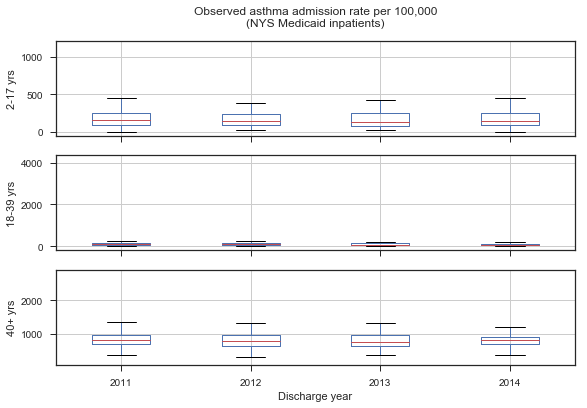

In [173]:
fig1, axes = plt.subplots(3, sharex = True, figsize = (9, 6))
for i, grp in enumerate(grps):
    medicaid_asthma.loc[medicaid_asthma['measure'] == grp].boxplot(
        'observed_rate',
        'year',
        ax = axes[i]
        )
for ax in axes:
    ax.set_xlabel('')
    ax.set_title('')
axes[2].set_xlabel('Discharge year')
axes[0].set_ylabel('2-17 yrs')
axes[1].set_ylabel('18-39 yrs')
axes[2].set_ylabel('40+ yrs')
t = ('Observed asthma admission rate per 100,000' +
     '\n' + '(NYS Medicaid inpatients)')
fig1.suptitle(t)

As above, with outliers (i.e. values >= 99th percentile) removed

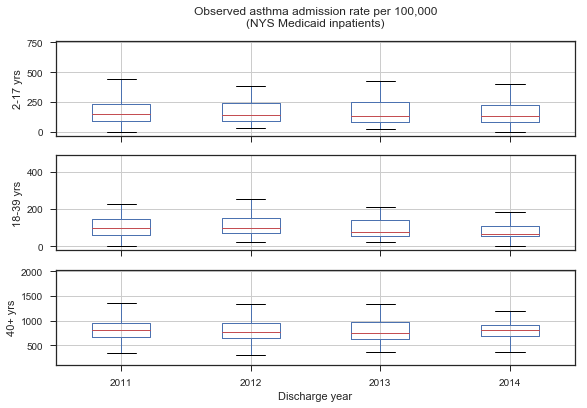

In [174]:
fig2, axes = plt.subplots(3, sharex = True, figsize = (9, 6))
for i, grp in enumerate(grps):
    p99 = medicaid_asthma.loc[(medicaid_asthma['measure'] == grp),
                              'observed_rate'].quantile(0.99)
    medicaid_asthma.loc[(medicaid_asthma['measure'] == grp) &
                        (medicaid_asthma['observed_rate'] < p99)].boxplot(
                            'observed_rate',
                            'year',
                            ax = axes[i]
                            )
for ax in axes:
    ax.set_xlabel('')
    ax.set_title('')
axes[2].set_xlabel('Discharge year')
axes[0].set_ylabel('2-17 yrs')
axes[1].set_ylabel('18-39 yrs')
axes[2].set_ylabel('40+ yrs')
t = ('Observed asthma admission rate per 100,000' +
     '\n' + '(NYS Medicaid inpatients)')
fig2.suptitle(t)

Side-by-side boxplots of annual asthma-related admission rates by age group for all NYS Medicaid inpatients

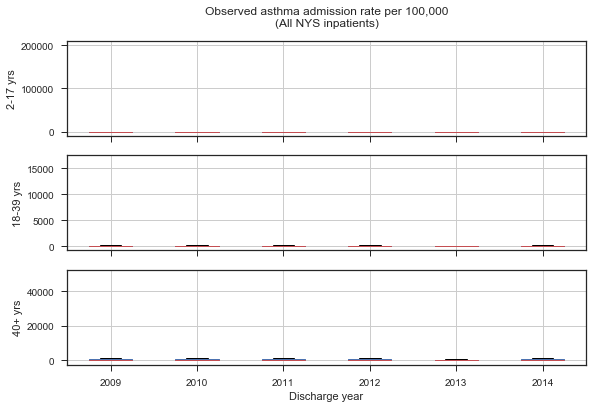

In [175]:
fig3, axes = plt.subplots(3, sharex = True, figsize = (9, 6))
for i, grp in enumerate(grps):
    inpt_asthma.loc[inpt_asthma['measure'] == grp].boxplot(
        'observed_rate',
        'year',
        ax = axes[i]
        )
for ax in axes:
    ax.set_xlabel('')
    ax.set_title('')
axes[2].set_xlabel('Discharge year')
axes[0].set_ylabel('2-17 yrs')
axes[1].set_ylabel('18-39 yrs')
axes[2].set_ylabel('40+ yrs')
t = ('Observed asthma admission rate per 100,000' +
     '\n' + '(All NYS inpatients)')
fig3.suptitle(t)

As above, with outliers (i.e. values >= 99th percentile) removed

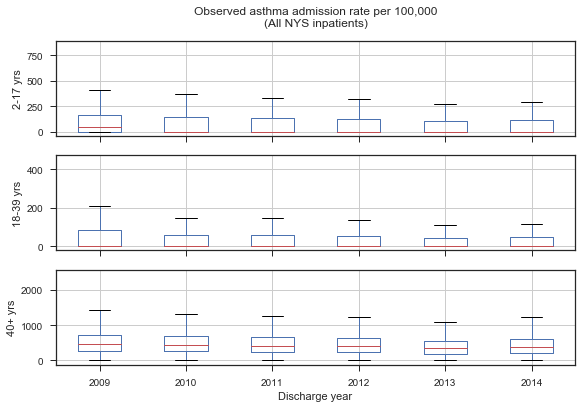

In [176]:
fig4, axes = plt.subplots(3, sharex = True, figsize = (9, 6))
for i, grp in enumerate(grps):
    p99 = inpt_asthma.loc[(inpt_asthma['measure'] == grp),
                              'observed_rate'].quantile(0.99)       
    inpt_asthma.loc[(inpt_asthma['measure'] == grp) &
                    (inpt_asthma['observed_rate'] < p99)].boxplot(
                        'observed_rate',
                        'year',
                        ax = axes[i]
                        )
for ax in axes:
    ax.set_xlabel('')
    ax.set_title('')
axes[2].set_xlabel('Discharge year')
axes[0].set_ylabel('2-17 yrs')
axes[1].set_ylabel('18-39 yrs')
axes[2].set_ylabel('40+ yrs')
t = ('Observed asthma admission rate per 100,000' +
     '\n' + '(All NYS inpatients)')
fig4.suptitle(t)

Histograms of NYS asthma-related admissions rates across age groups in 2014
- For Medicaid enrollees and all NYS inpatients
- With and without outliers

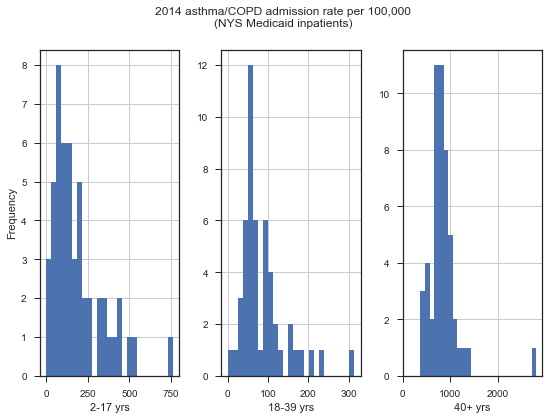

In [177]:
fig5, axes = plt.subplots(1, 3, figsize = (9, 6))
for i, grp in enumerate(grps):
    medicaid_14.loc[medicaid_14['measure'] == grp].hist(
        column = 'observed_rate',
        ax = axes[i],
        bins = 25
        )
for ax in axes:
    ax.set_title('')
    ax.set_xlim(left = min([0, ax.get_xlim()[0]]),
                right = ax.get_xlim()[1])
axes[0].set(xlabel = '2-17 yrs',
       ylabel = 'Frequency'
       )
axes[1].set(xlabel = '18-39 yrs',
       ylabel = ''
       )
axes[2].set(xlabel = '40+ yrs',
       ylabel = ''
       )
t = ('2014 asthma/COPD admission rate per 100,000' +
     '\n' + '(NYS Medicaid inpatients)')
fig5.suptitle(t)

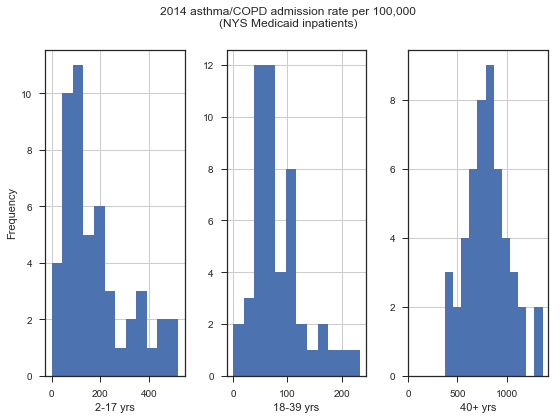

In [178]:
fig6, axes = plt.subplots(1, 3, figsize = (9, 6))
for i, grp in enumerate(grps):
    p99 = medicaid_14.loc[(medicaid_asthma['measure'] == grp),
                          'observed_rate'].quantile(0.99)
    medicaid_14.loc[(medicaid_14['measure'] == grp) &
                    (medicaid_14['observed_rate'] < p99)].hist(
                        column = 'observed_rate',
                        ax = axes[i],
                        bins = 12
                        )
for ax in axes:
    ax.set_title('')
    ax.set_xlim(left = min([0, ax.get_xlim()[0]]),
                right = ax.get_xlim()[1])
axes[0].set(xlabel = '2-17 yrs',
       ylabel = 'Frequency'
       )
axes[1].set(xlabel = '18-39 yrs',
       ylabel = ''
       )
axes[2].set(xlabel = '40+ yrs',
       ylabel = ''
       )
t = ('2014 asthma/COPD admission rate per 100,000' +
     '\n' + '(NYS Medicaid inpatients)')
fig6.suptitle(t)

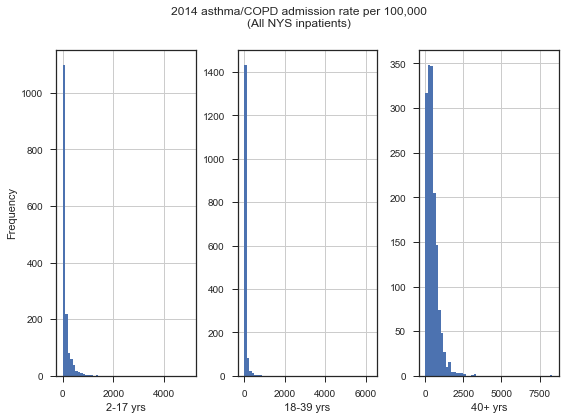

In [179]:
fig7, axes = plt.subplots(1, 3, figsize = (9, 6))
for i, grp in enumerate(grps):
    inpt_14.loc[inpt_14['measure'] == grp].hist(
        column = 'observed_rate',
        ax = axes[i],
        bins = 50
        )
for ax in axes:
    ax.set_title('')
    ax.set_xlim(left = min([0, ax.get_xlim()[0]]),
                right = ax.get_xlim()[1])
axes[0].set(xlabel = '2-17 yrs',
       ylabel = 'Frequency'
       )
axes[1].set(xlabel = '18-39 yrs',
       ylabel = ''
       )
axes[2].set(xlabel = '40+ yrs',
       ylabel = ''
       )
t = ('2014 asthma/COPD admission rate per 100,000' +
     '\n' + '(All NYS inpatients)')
fig7.suptitle(t)

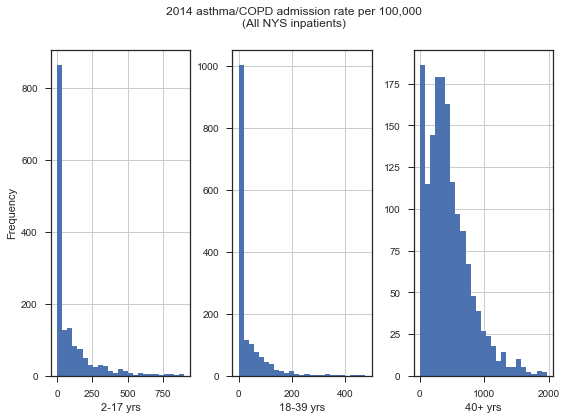

In [180]:
fig8, axes = plt.subplots(1, 3, figsize = (9, 6))
for i, grp in enumerate(grps):
    p99 = inpt_14.loc[(inpt_asthma['measure'] == grp),
                      'observed_rate'].quantile(0.99)
    inpt_14.loc[(inpt_14['measure'] == grp) &
                (inpt_14['observed_rate'] < p99)].hist(
                    column = 'observed_rate',
                    ax = axes[i],
                    bins = 25
                    )
for ax in axes:
    ax.set_title('')
    ax.set_xlim(left = min([0, ax.get_xlim()[0]]),
                right = ax.get_xlim()[1])
axes[0].set(xlabel = '2-17 yrs',
       ylabel = 'Frequency'
       )
axes[1].set(xlabel = '18-39 yrs',
       ylabel = ''
       )
axes[2].set(xlabel = '40+ yrs',
       ylabel = ''
       )
t = ('2014 asthma/COPD admission rate per 100,000' +
     '\n' + '(All NYS inpatients)')
fig8.suptitle(t)

Scatter plot matrices of 2014 asthma admission rates across age groups

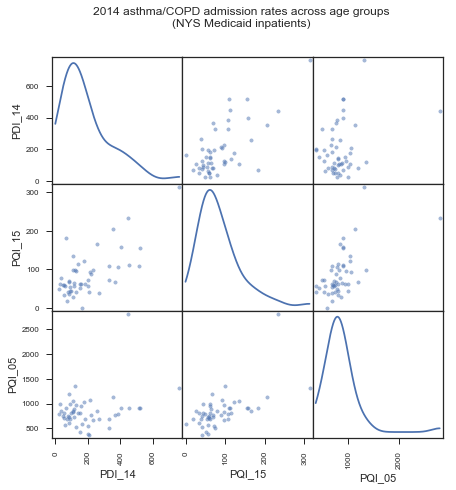

In [181]:
medicaid_14_wide = medicaid_14.pivot(index = 'zip_code',
                                     columns = 'measure',
                                     values = 'observed_rate'
                                     )[grps]
scatter_matrix(medicaid_14_wide,
               diagonal = 'kde',
               figsize = (7, 7))
t = ('2014 asthma/COPD admission rates across age groups' +
     '\n' + '(NYS Medicaid inpatients)')
plt.suptitle(t)

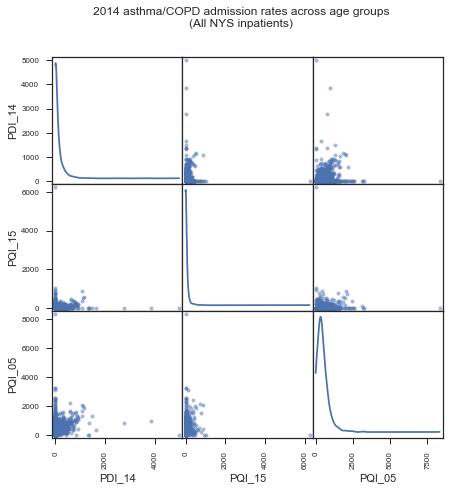

In [182]:
inpt_14_wide = inpt_14.pivot(index = 'zip_code',
                             columns = 'measure',
                             values = 'observed_rate'
                             )[grps]
scatter_matrix(inpt_14_wide,
               diagonal = 'kde',
               figsize = (7, 7))
t = ('2014 asthma/COPD admission rates across age groups' +
     '\n' + '(All NYS inpatients)')
plt.suptitle(t)

In [183]:
air_qual['var'] = air_qual['name'] + ' ' + air_qual['measure']
air_wide = air_qual.pivot_table(
    index = ['geo_entity_name', 'geo_entity_id'],
    columns = ['var'],
    values = 'data_valuemessage')
air_wide.reset_index(inplace = True)
air_wide['UHFCODE'] = air_wide['geo_entity_id'].astype('float64')

Scatter plot matrix of NYC air quality indicators

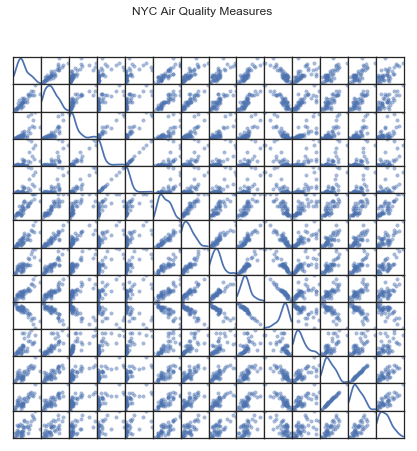

In [184]:
sm = scatter_matrix(
    air_wide[list(air_wide.columns[2:13]) +
             list(air_wide.columns[23:26])],
    diagonal = 'kde',
    figsize = (7, 7)
    )
for subaxis in sm:
    for ax in subaxis:
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
t = ('NYC Air Quality Measures')
plt.suptitle(t)

Import UHF Neighborhood and ZIP code crosswalk

In [185]:
url_uhf_zips = base + 'UHF_ZIP_Codes.csv'
uhf_zips = pd.read_csv(url_uhf_zips, 
                       index_col = 0,
                       dtype = {'zip_code': str, 
                                'neighborhood': str,
                                'uhf_code': float,
                                'zip_3': str})
uhf_zips.head()

,zip_code,neighborhood,uhf_code,zip_3
0,10001,Chelsea and Clinton,306.0,100
1,10002,Lower East Side,309.0,100
2,10003,Lower East Side,309.0,100
3,10004,Lower Manhattan,310.0,100
4,10005,Lower Manhattan,310.0,100


Pivot asthma hospitalizations data and join with UHF/ZIP codes dataframes

Compute mean admission rates by UHF neighborhood

In [186]:
medicaid_14 = medicaid_14.pivot_table(
    index = ['year', 'zip_code'],
    columns = 'measure',
    values = 'observed_rate').reset_index()
medicaid_14 = pd.merge(medicaid_14, 
                       uhf_zips,
                       left_on = ['zip_code'], 
                       right_on = ['zip_3'])
medicaid_14 = medicaid_14.groupby(
    ['neighborhood', 'uhf_code']
    )['PDI_14', 'PQI_05', 'PQI_15'].mean().reset_index()

In [187]:
medicaid_14.head()

,neighborhood,uhf_code,PDI_14,PQI_05,PQI_15
0,Borough Park,206.0,385.41,794.74,106.61
1,Bronx Park and Fordham,103.0,761.38,1314.30,313.56
2,Bushwick and Williamsburg,211.0,385.41,794.74,106.61
3,Canarsie and Flatlands,208.0,385.41,794.74,106.61
4,Central Bronx,105.0,761.38,1314.30,313.56


In [188]:
inpt_14 = inpt_14.pivot_table(index = ['year', 'zip_code'],
                              columns = 'measure',
                              values = 'observed_rate').reset_index()
inpt_14 = pd.merge(inpt_14, uhf_zips, how = 'left', on = ['zip_code'])
inpt_14 = inpt_14.groupby(
    ['neighborhood', 'uhf_code']
    )['PDI_14', 'PQI_05', 'PQI_15'].mean().reset_index()

In [189]:
inpt_14.head()

,neighborhood,uhf_code,PDI_14,PQI_05,PQI_15
0,Borough Park,206.0,65.840000,351.670000,26.180000
1,Bronx Park and Fordham,103.0,775.800000,1073.636667,176.550000
2,Bushwick and Williamsburg,211.0,412.086667,775.353333,83.343333
3,Canarsie and Flatlands,208.0,330.686667,839.300000,73.810000
4,Central Bronx,105.0,753.500000,1147.043333,207.166667


In [190]:
air = air_wide[list(air_wide.columns[2:13]) +
               list(air_wide.columns[23:27])]
air.columns = ['Avg Benzene',
               'Avg Formaldehyde',
               'NOx per km^2',
               'PM2.5 per km^2',
               'SO2 per km^2',
               'Avg EC',
               'Avg PM2.5',
               'Avg NO',
               'Avg NO2',
               'Avg O3',
               'Avg SO2',
               'VMT/100 km^2 Total',
               'VMT/100 km^2 Cars',
               'VMT/100 km^2 Trucks',
               'UHFCODE'
               ]

In [191]:
medicaid_14['uhf_code'] = medicaid_14['uhf_code'].apply(float)
inpt_14['uhf_code'] = inpt_14['uhf_code'].apply(float)

medicaid = pd.merge(medicaid_14, air, how = 'left',
                    left_on = ['uhf_code'], right_on = ['UHFCODE'])
medicaid.name = 'medicaid'

inpatient = pd.merge(inpt_14, air, how = 'left',
                     left_on = ['uhf_code'], right_on = ['UHFCODE'])
inpatient.name = 'inpatient'

Correlations between admission rates and air quality measures for both NYC Medicaid enrollees and all NYC inpatients

In [193]:
medicaid.corr().iloc[1:18, 1:4]

,PDI_14,PQI_05,PQI_15
PDI_14,1.000000,0.904187,0.894319
PQI_05,0.904187,1.000000,0.932022
PQI_15,0.894319,0.932022,1.000000
Avg Benzene,0.446094,0.388617,0.187734
Avg Formaldehyde,0.487705,0.365862,0.232466
NOx per km^2,0.367703,0.257394,0.163223
PM2.5 per km^2,0.338571,0.220020,0.166881
SO2 per km^2,0.330283,0.212845,0.160615
Avg EC,0.511725,0.376538,0.282107
Avg PM2.5,0.448483,0.340874,0.211266


In [195]:
inpatient.corr().iloc[1:18, 1:4]

,PDI_14,PQI_05,PQI_15
PDI_14,1.000000,0.890046,0.883864
PQI_05,0.890046,1.000000,0.911330
PQI_15,0.883864,0.911330,1.000000
Avg Benzene,-0.008430,-0.105831,-0.121146
Avg Formaldehyde,0.130068,0.024251,0.004382
NOx per km^2,-0.101013,-0.218343,-0.178145
PM2.5 per km^2,-0.106648,-0.221941,-0.176604
SO2 per km^2,-0.110638,-0.226114,-0.180892
Avg EC,0.165849,0.073449,0.067456
Avg PM2.5,0.056412,-0.043733,-0.058439


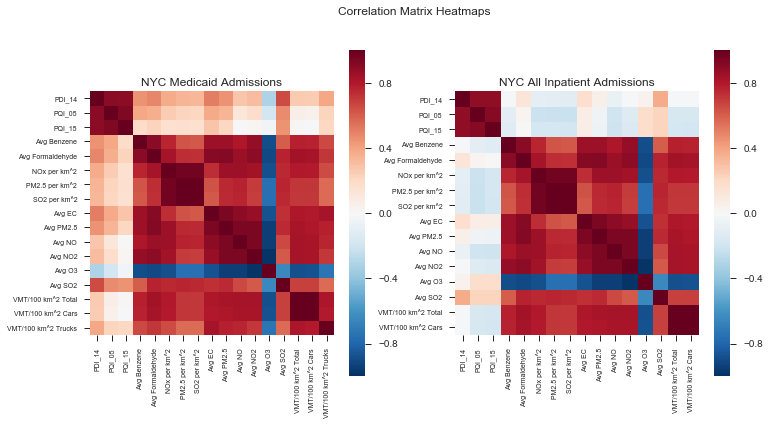

In [196]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(medicaid.corr().iloc[1:18, 1:18],
            square = True, ax = ax1)
ax1.set_title('NYC Medicaid Admissions')
ax1.set_yticklabels(
    ax1.yaxis.get_ticklabels(),
    rotation = 0, fontsize = 7
    )
ax1.set_xticklabels(
    ax1.xaxis.get_ticklabels(),
    rotation = 90, fontsize = 7
    )

sns.heatmap(inpatient.corr().iloc[1:17, 1:17],
            square = True, ax = ax2)
ax2.set_title('NYC All Inpatient Admissions')
ax2.set_yticklabels(
    ax2.yaxis.get_ticklabels(),
    rotation = 0, fontsize = 7
    )
ax2.set_xticklabels(
    ax2.xaxis.get_ticklabels(),
    rotation = 90, fontsize = 7
    )
plt.suptitle('Correlation Matrix Heatmaps')

Create widgets for user selection of scatter plot and mapping parameters

In [198]:
dfs = {'inpatient': inpatient, 'medicaid': medicaid}

ages = list(zip(['2-17 yr olds', '18-39 yr olds', '40+ yr olds'], grps))

select1 = Dropdown(options = {'All Inpatient Admissions': 'inpatient', 
                              'All Medicaid Admissions': 'medicaid'}, 
                   description = 'Hospitalization Data ')
select2 = Dropdown(options = list(air)[:-1], description = 'Air Quality Indicator')
select3 = Dropdown(options = ages, description = 'Age Group')
make_plots = Button(description = 'Make/Update Plots')

Run function to get and unzip UHF Neighborhood shapefile archive to current working directory

In [199]:
get_unzip_shp()

Scatter plot and chloropleth maps

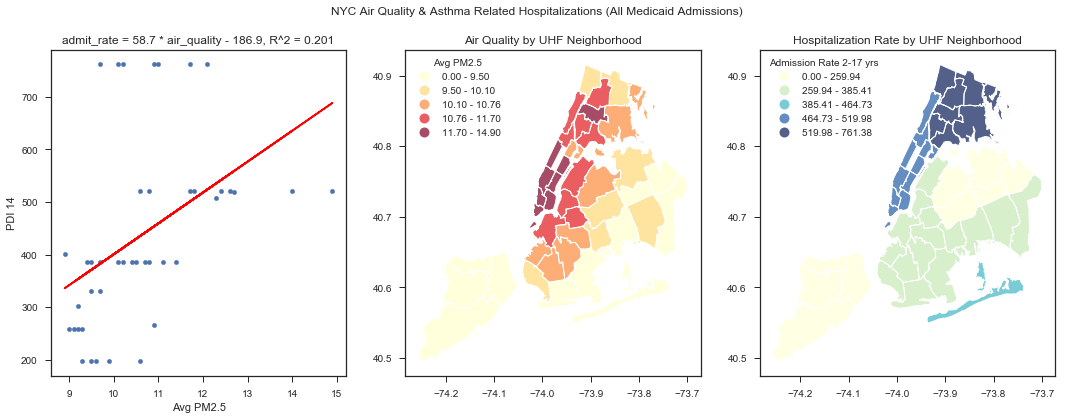

In [200]:
def reactive_maps(b):
    clear_output()
    if 'm1' in locals():
        plt.cla(m1)   
        plt.clf(m1) 
    if 'm2' in locals():
        plt.cla(m2)   
        plt.clf(m2) 
    plt.close() 
    m1 = corr_map(dfs[select1.value], select2.value, select3.value)
    m2 = folium_map(dfs[select1.value], select2.value, select3.value)
    display(m1, m2)

display(VBox([HBox([select1, select2, select3]),
      make_plots]))

make_plots.on_click(reactive_maps)

The results of this analysis should be taken with at least a few grains of salt given the differences in measurement years across variables within and between datasets as well as differences in the spatial resolution of the observations in each of the datasets.  The NYS Medicaid inpatient quality measures were reported by the first three digits of discharged patients' ZIP codes, the corresponding measures for all NYS inpatients were reported by 5-digit ZIP code, and the NYC air quality indicators data were reported by United Health Fund (UHF) neighborhood, which group the city's 178 ZIP code areas into 42 larger groupings that are widely used in public health reporting in NYC.  In my analysis, I ignored temporal differences between the air quality measures and asthma-related admissions rates; admissions data were limited to 2014 discharges.  In order to accomodate the different spatial units used in the sourced data, I calculated mean admission rates by UHF neighborhood for the corresponding Medicaid and total inpatient admissions observations.  This approach worked well enough in the current context, but publication of more granular measures of asthma-related hospitalizations among Medicaid enrollees would allow for greater precision and perhaps different findings.  My approach could be further developed with population counts by ZIP code area in order to calculate weighted averages of admission rates or estimate true admission rates by UHF neighborhood.  

The most surprising finding in my analysis was the negative correlation between average ozone (O3) concentration and all of the other air quality measures across UHF neighborhoods, which is immediately apparent in the correlation matrix heatmaps above.  The negative correlation between nitrous oxide (NOx) per square km and average ozone concentration does raise the possibility of measurement or other errors in the dataset given that nitrous oxide is a precursor of ozone, and so one would expect a strong positive correlation between these two variables.  Another interesting result is the larger number of differences in the direction of the relationship between the air quality and admission rate variable pairs when one compares the Medcaid enrollee and total inpatient datasets.  This may be due in part to the differences in spatial resolution described above (notice the stepped appearance of the scatter plots of a given air quality indicator against a given age group's admission rates for Medicaid enrollees), but may also reflect the disproportionate risk of asthma-related hospitalization for Medicaid enrollees relative to the inpatient population as a whole; this difference in relative risk is evident in the side-by-side box plots and histograms of admission rates at the beginning of my exploratory data analysis and visualization.  While there is certainly significant room for extension and refinement, this analysis does speak to the value of public reporting of environmental and community health data and the utility of statistical and geospatial analysis.